In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/skin_cancer_datasets/ISIC_benign_malignant_augmented_split.zip

Streaming output truncated to the last 5000 lines.
 extracting: train/Benign/ISIC_0000349_flipped_v.jpg  
 extracting: train/Benign/ISIC_0025677_flipped_h.jpg  
 extracting: train/Benign/ISIC_0000021_flipped_hv.jpg  
 extracting: train/Benign/ISIC_0032135_flipped_hv.jpg  
 extracting: train/Benign/ISIC_0027903_flipped_hv.jpg  
 extracting: train/Benign/ISIC_0000320_flipped_h.jpg  
 extracting: train/Benign/ISIC_0026912_flipped_hv.jpg  
 extracting: train/Benign/ISIC_0000333_flipped_hv.jpg  
 extracting: train/Benign/ISIC_0026265.jpg  
 extracting: train/Benign/ISIC_0011012_flipped_hv.jpg  
 extracting: train/Benign/ISIC_0031271_flipped_h.jpg  
 extracting: train/Benign/ISIC_0000467.jpg  
 extracting: train/Benign/ISIC_0027770_flipped_h.jpg  
 extracting: train/Benign/ISIC_0000408_flipped_hv.jpg  
 extracting: train/Benign/ISIC_0028662_flipped_v.jpg  
 extracting: train/Benign/ISIC_0028188.jpg  
 extracting: train/Benign/ISIC_0024490_flipped_hv.jpg  
 extracting: train/Benign/ISIC_00267

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG16, InceptionV3, DenseNet121, EfficientNetB0, Xception, MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
# Paths
#dataset_path = "/content/ISIC_benign_malignant_augmented_split"
train_dir = '/content/train'
val_dir = '/content/val'
test_dir = '/content/test'

In [ ]:
# Image Parameters
img_height, img_width = 128, 128
batch_size = 32
num_classes = 2

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255  # Normalize pixel values to [0, 1]
)

# Generator for training
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="binary",
)

val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="binary",
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="binary",
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False,
)

Found 7295 images belonging to 2 classes.
Found 7295 images belonging to 2 classes.
Found 912 images belonging to 2 classes.
Found 913 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dense, GlobalAveragePooling2D, Multiply

# Squeeze-and-Excitation Block
class SqueezeExcitationLayer(tf.keras.layers.Layer):
    def __init__(self, reduction_ratio=8):
        super(SqueezeExcitationLayer, self).__init__()
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        channel = input_shape[-1]
        self.dense1 = Dense(channel // self.reduction_ratio, activation='relu', use_bias=False)
        self.dense2 = Dense(channel, activation='sigmoid', use_bias=False)

    def call(self, inputs):
        # Squeeze: Global Average Pooling
        squeeze = GlobalAveragePooling2D()(inputs)

        # Excitation: Fully Connected Layers
        excitation = self.dense2(self.dense1(squeeze))
        excitation = tf.reshape(excitation, [-1, 1, 1, inputs.shape[-1]])

        # Scale: Multiply input by excitation weights
        scale = Multiply()([inputs, excitation])
        return scale

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2
model = tf.keras.Sequential([
    Conv2D(32, (3, 3), input_shape=(128, 128, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    SqueezeExcitationLayer(),
    Conv2D(64, (3, 3),  activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3),  activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    SqueezeExcitationLayer(),
    Conv2D(128, (3, 3),  activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3),  activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    SqueezeExcitationLayer(),
    Conv2D(256, (3, 3),  activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 124, 124, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 124, 124, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ squeeze_excitation_layer             │ (None, 62, 62, 32)          │             256 │
│ (SqueezeExcitationLayer)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 60, 60, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 58, 58, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 58, 58, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 29, 29, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ squeeze_excitation_layer_1           │ (None, 29, 29, 64)          │           1,024 │
│ (SqueezeExcitationLayer)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 27, 27, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 27, 27, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 25, 25, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 25, 25, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 634,529 (2.42 MB)

 Trainable params: 632,673 (2.41 MB)

 Non-trainable params: 1,856 (7.25 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Reduce learning rate on plateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=1,
    restore_best_weights=True
)
# Start training
history = model.fit(
    train_generator,
    epochs=80,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
    )

Epoch 1/80


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


228/228 ━━━━━━━━━━━━━━━━━━━━ 45s 118ms/step - accuracy: 0.6055 - loss: 0.6957 - val_accuracy: 0.4627 - val_loss: 0.7863 - learning_rate: 0.0010
Epoch 2/80
228/228 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.6613 - loss: 0.6026 - val_accuracy: 0.5987 - val_loss: 0.6733 - learning_rate: 0.0010
Epoch 3/80
228/228 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.6886 - loss: 0.5865 - val_accuracy: 0.6096 - val_loss: 0.7159 - learning_rate: 0.0010
Epoch 4/80
228/228 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - accuracy: 0.7130 - loss: 0.5580 - val_accuracy: 0.6151 - val_loss: 0.7066 - learning_rate: 0.0010
Epoch 5/80
228/228 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.7300 - loss: 0.5349 - val_accuracy: 0.5855 - val_loss: 0.7542 - learning_rate: 0.0010
Epoch 6/80
228/228 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.7419 - loss: 0.5280 - val_accuracy: 0.6338 - val_loss: 0.7797 - learning_rate: 0.0010
Epoch 7/80
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7612 - loss: 0.5012

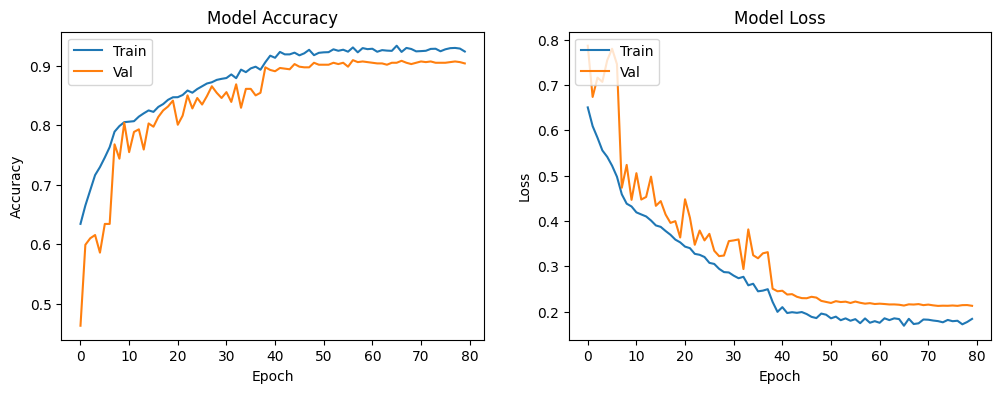

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np

# Get predictions on the test data
test_steps = test_generator.samples // test_generator.batch_size
predictions = model.predict(test_generator, steps=test_steps + 1)
predicted_classes = (predictions > 0.5).astype(int).flatten()  # Convert probabilities to binary predictions

# Get true labels
true_classes = test_generator.classes
class_indices = test_generator.class_indices  # Mapping of class names to labels

# Evaluate metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes)
recall = recall_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_indices.keys()))


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step
Accuracy: 0.8949
Precision: 0.9045
Recall: 0.8612
F1 Score: 0.8824

Classification Report:
              precision    recall  f1-score   support

      Benign       0.89      0.92      0.90       495
   Malignant       0.90      0.86      0.88       418

    accuracy                           0.89       913
   macro avg       0.90      0.89      0.89       913
weighted avg       0.90      0.89      0.89       913



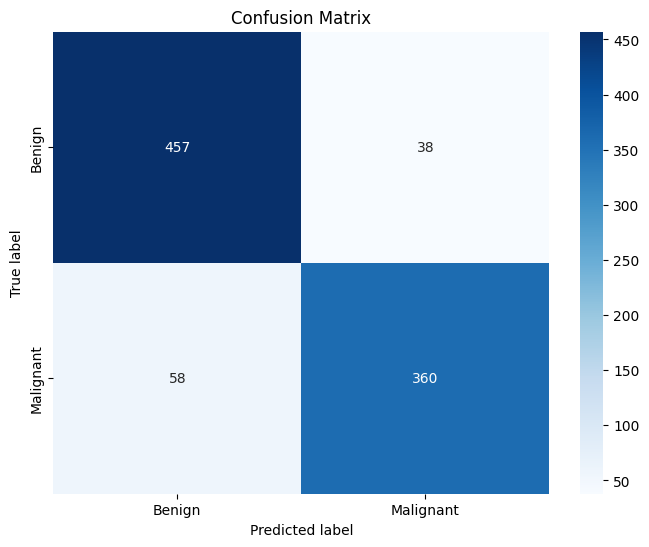

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
model_path = '/content/drive/MyDrive/skin_cancer_models/CNN_SAE.h5'

# Save the model
model.save(model_path)

print(f"Model saved to {model_path}")

Model saved to /content/drive/MyDrive/skin_cancer_models/CNN_SAE.h5
